In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from pyzipcode import ZipCodeDatabase

In [27]:
class RoofImóveis():
    """
        A empresa te contratou pois quer saber qual seria os 5 imóveis que
        ela deveria investir e o porquê e quais 5 você não recomendaria o
        investimento de jeito nenhum.
    """

    def __init__(self):
        path = r'../data/kc_house_data.csv'
        
        self.df = pd.read_csv(
            filepath_or_buffer=path,
            date_parser=['date'],
            sep=',',
            decimal='.',
        )

    def convertendo_a_coluna_date_para_o_tipo_datetime(self):
        self.df['date'] = pd.to_datetime(
            arg=self.df['date'],
            format='%Y%m%dT%H%M%S'
        )

    def removendo_ids_duplicados(self):
        self.df = self.df.sort_values(
            by='date',
            ascending=False
        ).drop_duplicates(subset=['id'])

    def transformando_as_colunas_bathrooms_e_floors_em_inteiros(self):
        self.df['bathrooms'] = self.df['bathrooms'].astype(int)
        self.df['floors'] = self.df['floors'].astype(int)

    def criando_a_coluna_city(self):
        zcdb = ZipCodeDatabase()
        city = []

        for zipcode in self.df['zipcode']:
            try:
                zc = zcdb[zipcode]
                city.append(zc.city)
                
            except KeyError:
                if zipcode == 98077:
                    city.append(str('Woodinville'))
                else:
                    city.append(str('nan'))
        
        self.df['city'] = city

    def média_do_valor_do_ft2_por_cidade(self):
        df = self.df[
            [
                'city',
                'price',
                'sqft_lot',
            ]
        ]

        self.df['price_of_ft2'] = df['price_of_ft2_per_city'] = df['price'] / df['sqft_lot']

        df = df[(np.abs(stats.zscore(df['price_of_ft2_per_city'])) < 3)]
        df = df.groupby('city').agg({'price_of_ft2_per_city': 'mean'}).reset_index()

        price_of_ft2_per_city = []

        for city in self.df['city']:
            pompc = df[
                (df['city'] == city)
            ]['price_of_ft2_per_city'].iloc[0]

            price_of_ft2_per_city.append(pompc)

        self.df['price_of_ft2_per_city'] = price_of_ft2_per_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df,
            x="price_of_ft2_per_city",
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )

        plt.show()

    def média_do_tamanho_do_terreno_por_cidade(self):
        df = self.df[
            [
                'city',
                'sqft_lot',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['sqft_lot'])) < 3)]
        df = df.groupby('city').agg({'sqft_lot': 'mean'}).reset_index()

        plot_size_by_city = []

        for city in self.df['city']:
            sqft_lot = df[
                (df['city'] == city)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city.append(sqft_lot)

        self.df['plot_size_by_city'] = plot_size_by_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df, 
            x="sqft_lot", 
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )
            
        plt.show()

    def média_de_quantidade_quartos_por_cidade(self):
        df = self.df[
            [
                'city',
                'bedrooms',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['bedrooms'])) < 3)]
        df = df.groupby('city').agg({'bedrooms': 'mean'}).astype(int).reset_index()

        bedrooms_by_city = []

        for city in self.df['city']:
            rbc = df[
                (df['city'] == city)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city.append(rbc)

        self.df['bedrooms_by_city'] = bedrooms_by_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df, 
            x="bedrooms", 
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )
            
        plt.show()

    def média_de_quantidade_banheiros_por_cidade(self):
        df = self.df[
            [
                'city',
                'bathrooms',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['bathrooms'])) < 3)]
        df = df.groupby('city').agg({'bathrooms': 'mean'}).astype(int).reset_index()

        bathrooms_by_city = []

        for city in self.df['city']:
            bbc = df[
                (df['city'] == city)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city.append(bbc)

        self.df['bathrooms_by_city'] = bathrooms_by_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df, 
            x="bathrooms", 
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )
            
        plt.show()

    def filtrando_os_melhores_imóveis(
        self,
        condition_min=5,
        yr_built_min=1980,
        bedrooms_min=1,
        bathrooms_min=1,
        price_max=1000000.0,
    ):

        df = self.df[
            (self.df['price'] / self.df['sqft_lot'] < self.df['price_of_ft2_per_city']) &
            (self.df['condition'] == condition_min) &
            (self.df['yr_built'] >= yr_built_min) &
            (self.df['bedrooms'] >= bedrooms_min) &
            (self.df['bathrooms'] >= bathrooms_min) &
            (self.df['price'] <= price_max)
        ].sort_values(by='price').reset_index()

        self.imóveis_filtrados = df

        print("""
        Filtros:
            condition_min = 5,
            yr_built_min = 1980,
            bedrooms_min = 1,
            bathrooms_min = 1,
            price_max = 1000000.0,
        """)

    def algoritmo_de_rankeamento_dos_melhores_imóveis(self):

        self.rank_dos_imóveis = {}
        cidades_mais_populosas = [
            'Seattle', 
            'Spokane',
            'Tacoma',
            'Vancouver',
            'Bellevue',
            'Kent',
            'Everett',
            'Renton',
            'Federal Way',
            'Spokane Valley',
        ]

        for id in self.imóveis_filtrados['id']:
            self.rank_dos_imóveis[id] = 0

            city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['city'].iloc[0]

            price_of_ft2 = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['price_of_ft2'].iloc[0]

            price_of_ft2_per_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['price_of_ft2_per_city'].iloc[0]

            sqft_lot = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['plot_size_by_city'].iloc[0]

            bedrooms = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bedrooms_by_city'].iloc[0]

            bathrooms = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bathrooms_by_city'].iloc[0]


            resultado = (price_of_ft2_per_city - price_of_ft2) / price_of_ft2 * 100

            if city in cidades_mais_populosas:
                self.rank_dos_imóveis[id] += 30

            if resultado > 50:
                self.rank_dos_imóveis[id] += 30

            if sqft_lot > plot_size_by_city:
                self.rank_dos_imóveis[id] += 20 

            if bedrooms > bedrooms_by_city:
                self.rank_dos_imóveis[id] += 10

            if bathrooms > bathrooms_by_city:
                self.rank_dos_imóveis[id] += 10

        print("""
        Valor de cada metrica:
            Localização, top 10 cidades + populosas = 30,
            Valor do ft2 < abaixo da média da cidade = 30
            Tamanho do terreno > que a média da cidade = 20,
            Quartos > que a média da cidade = 10,
            Banheiros > que a média da cidade = 10,
        """)

    def os_5_melhores_imóveis(self):

        notas_ordenadas = sorted(self.rank_dos_imóveis.values(), reverse=True)
        cinco_maiores_notas = notas_ordenadas[:5]

        ids = [k for k, v in self.rank_dos_imóveis.items() if v in cinco_maiores_notas]
        self.ids = ids[:5]

        df = self.df[
            (self.df['id'].isin(self.ids))
        ].sort_values(by='price').reset_index()

        display(
            df[
                [
                    'id',
                    'city',
                    'price',
                    'sqft_lot',
                    'price_of_ft2',
                    'price_of_ft2_per_city',
                    'condition',
                    'yr_built',
                    'bedrooms',
                    'bathrooms',
                ]
            ]
        )

    def filtrando_os_piores_imóveis(
        self,
        condition_max=2,
        yr_built_max=1980,
    ):

        df = self.df[
            (self.df['price'] / self.df['sqft_lot'] > self.df['price_of_ft2_per_city']) &
            (self.df['condition'] <= condition_max) &
            (self.df['yr_built'] < yr_built_max)
        ].sort_values(by='price').reset_index()

        self.piores_imóveis_filtrados = df

        print("""
        Filtros:
            condition_max = 2,
            yr_built_max = 1980,
        """)

    def algoritmo_de_rankeamento_dos_piores_imóveis(self):

        self.rank_dos_piores_imóveis = {}
        cidades_mais_populosas = [
            'Seattle', 
            'Spokane',
            'Tacoma',
            'Vancouver',
            'Bellevue',
            'Kent',
            'Everett',
            'Renton',
            'Federal Way',
            'Spokane Valley',
        ]

        for id in self.piores_imóveis_filtrados['id']:
            self.rank_dos_piores_imóveis[id] = 0

            city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['city'].iloc[0]

            price_of_ft2 = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['price_of_ft2'].iloc[0]

            price_of_ft2_per_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['price_of_ft2_per_city'].iloc[0]

            sqft_lot = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['plot_size_by_city'].iloc[0]

            bedrooms = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bedrooms_by_city'].iloc[0]

            bathrooms = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bathrooms_by_city'].iloc[0]


            resultado = (price_of_ft2_per_city - price_of_ft2) / price_of_ft2 * 100


            if city not in cidades_mais_populosas:
                self.rank_dos_piores_imóveis[id] += 30

            if resultado < -50:
                self.rank_dos_piores_imóveis[id] += 30

            if sqft_lot < plot_size_by_city:
                self.rank_dos_piores_imóveis[id] += 20 

            if bedrooms < bedrooms_by_city:
                self.rank_dos_piores_imóveis[id] += 10

            if bathrooms < bathrooms_by_city:
                self.rank_dos_piores_imóveis[id] += 10

        print("""
        Valor de cada metrica:
            Localização, fora do top 10 cidades + populosas = 30,
            Valor do ft2 > acima da média da cidade = 30,
            Tamanho do terreno < que a média da cidade = 20,
            Quartos < que a média da cidade = 10,
            Banheiros < que a média da cidade = 10,
        """)

    def os_5_piores_imóveis(self):

        notas_ordenadas = sorted(self.rank_dos_piores_imóveis.values(), reverse=True)
        cinco_maiores_notas = notas_ordenadas[:5]

        ids = [k for k, v in self.rank_dos_piores_imóveis.items() if v in cinco_maiores_notas]
        self.os_piores_ids = ids[:5]

        df = self.df[
            (self.df['id'].isin(self.os_piores_ids))
        ].sort_values(
            by='price',
            ascending=False
        ).reset_index()

        display(
            df[
                [
                    'id',
                    'city',
                    'price',
                    'sqft_lot',
                    'price_of_ft2',
                    'price_of_ft2_per_city',
                    'condition',
                    'yr_built',
                    'bedrooms',
                    'bathrooms',
                ]
            ]
        )

    def relatório(self):
        conteudo = f"""# Roof Imóveis:
## Overview:
Primeiramente, definimos o público-alvo como casais com filhos. Em seguida, determinamos as métricas, como localização, preço, condições do imóvel, entre outros.

Com tudo isso em mente, iniciamos as análises e concluímos quais os cinco imóveis que deveriam ser investidos e por quê, e quais cinco não recomendaríamos o investimento de jeito nenhum.

## Os 5 imóveis que deveriam ser investidos:
1. > O imóvel de ID: {self.ids[0]} está localizado em {self.df[(self.df['id'] == self.ids[0])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.ids[0])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.ids[0])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.ids[0])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.ids[0])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.ids[0])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.ids[0])]['sqft_living'].iloc[0]}.
2. > O imóvel de ID: {self.ids[1]} está localizado em {self.df[(self.df['id'] == self.ids[1])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.ids[1])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.ids[1])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.ids[1])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.ids[1])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.ids[1])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.ids[1])]['sqft_living'].iloc[0]}.
3. > O imóvel de ID: {self.ids[2]} está localizado em {self.df[(self.df['id'] == self.ids[2])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.ids[2])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.ids[2])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.ids[2])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.ids[2])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.ids[2])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.ids[2])]['sqft_living'].iloc[0]}.
4. > O imóvel de ID: {self.ids[3]} está localizado em {self.df[(self.df['id'] == self.ids[3])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.ids[3])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.ids[3])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.ids[3])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.ids[3])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.ids[3])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.ids[3])]['sqft_living'].iloc[0]}.
5. > O imóvel de ID: {self.ids[4]} está localizado em {self.df[(self.df['id'] == self.ids[4])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.ids[4])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.ids[4])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.ids[4])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.ids[4])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.ids[4])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.ids[4])]['sqft_living'].iloc[0]}.

## Os 5 imóveis que NÃO deveriam ser investidos::
1. > O imóvel de ID: {self.os_piores_ids[0]} está localizado em {self.df[(self.df['id'] == self.os_piores_ids[0])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.os_piores_ids[0])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.os_piores_ids[0])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.os_piores_ids[0])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.os_piores_ids[0])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.os_piores_ids[0])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.os_piores_ids[0])]['sqft_living'].iloc[0]}.
2. > O imóvel de ID: {self.os_piores_ids[1]} está localizado em {self.df[(self.df['id'] == self.os_piores_ids[1])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.os_piores_ids[1])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.os_piores_ids[1])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.os_piores_ids[1])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.os_piores_ids[1])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.os_piores_ids[1])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.os_piores_ids[1])]['sqft_living'].iloc[0]}.
3. > O imóvel de ID: {self.os_piores_ids[2]} está localizado em {self.df[(self.df['id'] == self.os_piores_ids[2])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.os_piores_ids[2])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.os_piores_ids[2])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.os_piores_ids[2])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.os_piores_ids[2])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.os_piores_ids[2])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.os_piores_ids[2])]['sqft_living'].iloc[0]}.
4. > O imóvel de ID: {self.os_piores_ids[3]} está localizado em {self.df[(self.df['id'] == self.os_piores_ids[3])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.os_piores_ids[3])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.os_piores_ids[3])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.os_piores_ids[3])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.os_piores_ids[3])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.os_piores_ids[3])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.os_piores_ids[3])]['sqft_living'].iloc[0]}.
5. > O imóvel de ID: {self.os_piores_ids[4]} está localizado em {self.df[(self.df['id'] == self.os_piores_ids[4])]['city'].iloc[0]}, sendo vendido por ${self.df[(self.df['id'] == self.os_piores_ids[4])]['price'].iloc[0]} com valor do pé quadrado de ${self.df[(self.df['id'] == self.os_piores_ids[4])]['price_of_ft2'].iloc[0]}, tamanho do terreno de {self.df[(self.df['id'] == self.os_piores_ids[4])]['sqft_lot'].iloc[0]}, {self.df[(self.df['id'] == self.os_piores_ids[4])]['bedrooms'].iloc[0]} quarto(s) e {self.df[(self.df['id'] == self.os_piores_ids[4])]['bathrooms'].iloc[0]} banheiro(s), com área habitável de {self.df[(self.df['id'] == self.os_piores_ids[4])]['sqft_living'].iloc[0]}.

## Observações:
Para obtermos uma análise mais precisa, é necessário definir qual é o objetivo da compra do imóvel: revenda, aluguel ou uso próprio. Além disso, é importante identificar o público-alvo, como casais sem filhos, casais com filhos, solteiros ou estudantes. Também é necessário definir o tipo de imóvel desejado, se é de alto padrão ou popular, e qual o valor máximo do investimento.

Em relação aos dados, seria mais simples se tivéssemos acesso ao valor do metro quadrado por cidade. É importante observar se os imóveis recomendados estão bem localizados, por exemplo, se há escolas próximas e se estão próximos ao centro da cidade, entre outros fatores.

## Possíveis públicos-alvo:
- Casais sem filhos
- Casais com filhos
- Solteiros
- Estudantes

## Métricas de avaliação do imóvel:
1. Localização: o imóvel deve estar em uma das 10 cidades mais populosas de Washington.
2. Valor do metro quadrado: deve ser menor que a média da cidade.
3. Preço: deve ser menor que a média da cidade.
4. Condição do imóvel: a condição do imóvel deve ser igual a 5.
5. Tamanho do terreno: deve ser maior que a média da cidade.
6. Quantidade de quartos: deve ser maior que a média da cidade.
7. Quantidade de banheiros: deve ser maior que a média da cidade.
8. Ano de construção: deve ser maior que 1980.

## Insights técnicos da análise:
1. Ao iniciar a análise dos dados, deparei-me com a coluna `bathrooms` e percebi que havia informações referentes a casas com, por exemplo, 2.25, 4.50, 1.75 banheiros. Esses valores não faziam sentido para a minha análise. Então, optei por convertê-los em números inteiros. Lembrando que pesquisei e descobri que esses dados significam que o banheiro em questão não é completo, ou seja, possui todos os itens que um banheiro normalmente tem, exceto pelo chuveiro, a pia ou o vaso sanitário. Apesar disso, concluí que esses dados não eram relevantes para a minha análise.

2. Posteriormente, encontrei uma situação semelhante na coluna `floors`, onde havia informações referentes a casas com 1.5, 2.5, 3.5 andares. Como essa coluna indicava o número de andares da casa, optei por convertê-los em números inteiros também.

3. Ao analisar o dataframe, identifiquei 353 imóveis que haviam sido vendidos mais de uma vez. Uma das métricas sugeridas foi a valorização desses imóveis. No entanto, optei por ignorar essa métrica por dois motivos. Primeiramente, uma valorização passada não necessariamente indica uma valorização futura. Além disso, dos 21613 imóveis analisados, apenas 353 haviam sido vendidos mais de uma vez. Portanto, optei por remover os IDs duplicados.

4. Por fim, mas não menos importante, criei um `algoritmo de ranqueamento de imóveis`. Esse algoritmo consiste em atribuir notas aos imóveis filtrados previamente. Cada critério estipulado tem um peso maior ou menor dependendo do caso, sendo que a nota máxima que um imóvel pode receber é 100. Antes de atribuirmos notas aos imóveis, precisamos filtrar os dados. Como temos mais de 21 mil linhas, utilizei os seguintes filtros: condição mínima igual a 5, ano de construção maior ou igual a 1980, número de quartos maior ou igual a 1, número de banheiros maior ou igual a 1 e preço máximo menor ou igual a 1 milhão. Após a filtragem, chegou o momento de ranquear os imóveis. Os critérios utilizados para ranqueá-los foram: `localização`, se o imóvel está dentro das 10 cidades mais populosas, ele ganha 30 pontos; `valor do ft2`, se o imóvel estiver com um valor do ft2 abaixo da média da cidade, concluo que ele está subvalorizado e ganhará mais 30 pontos; `tamanho do terreno`, se o imóvel for maior que a média da cidade, ganhará mais 20 pontos; `número de quartos`, se o imóvel tiver mais quartos que a média da cidade, ganhará mais 10 pontos; `número de banheiros`, se o imóvel tiver mais banheiros que a média da cidade, ganhará mais 10 pontos.

Critérios  | Notas
--------- | ----
Cidade    | 30
Valor do ft2    | 30
Tamanho do terreno    | 20
Quartos    | 10
Banheiros    | 10

---
Linkedin: <https://www.linkedin.com/in/samuel-barbosa-dev/> 

E-mail: <samueloficial@protonmail.com>"""
        with open(f"../../README.md", "w") as file:
                file.write(str(conteudo))

        print('Relatório criado, README.md.')


if __name__ == '__main__':
    roof_imóveis = RoofImóveis()

In [28]:
roof_imóveis.convertendo_a_coluna_date_para_o_tipo_datetime()

In [29]:
roof_imóveis.removendo_ids_duplicados()

In [30]:
roof_imóveis.transformando_as_colunas_bathrooms_e_floors_em_inteiros()

In [31]:
roof_imóveis.criando_a_coluna_city()

/tmp/ipykernel_42235/3515198350.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['price_of_ft2'] = df['price_of_ft2_per_city'] = df['price'] / df['sqft_lot']


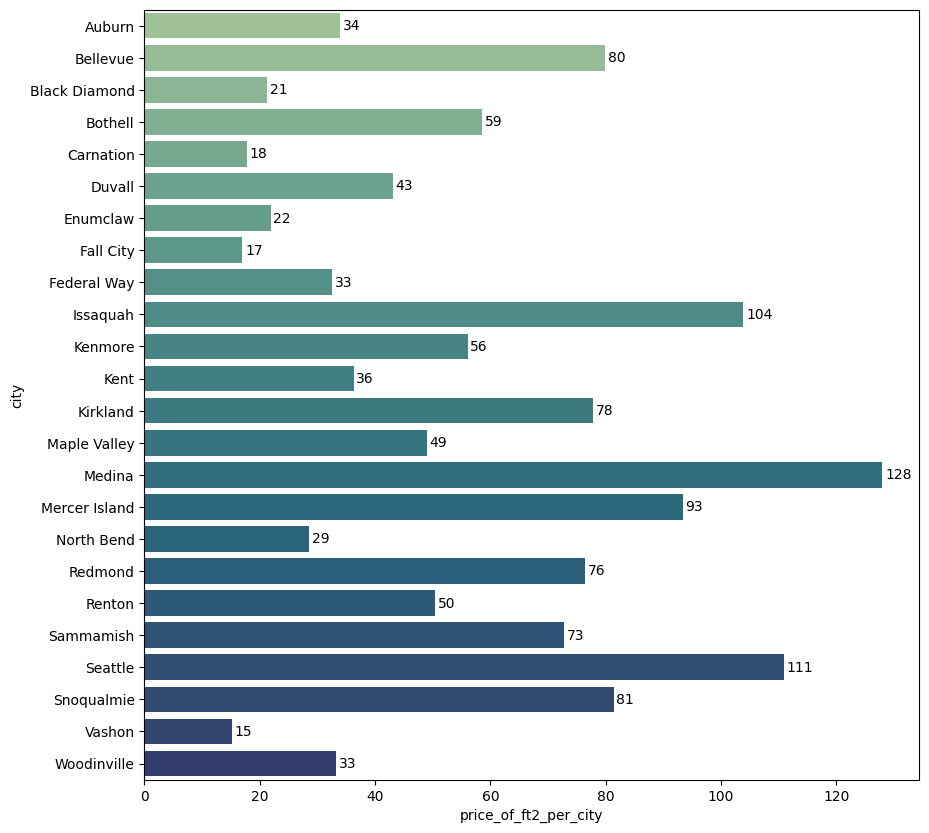

In [32]:
roof_imóveis.média_do_valor_do_ft2_por_cidade()

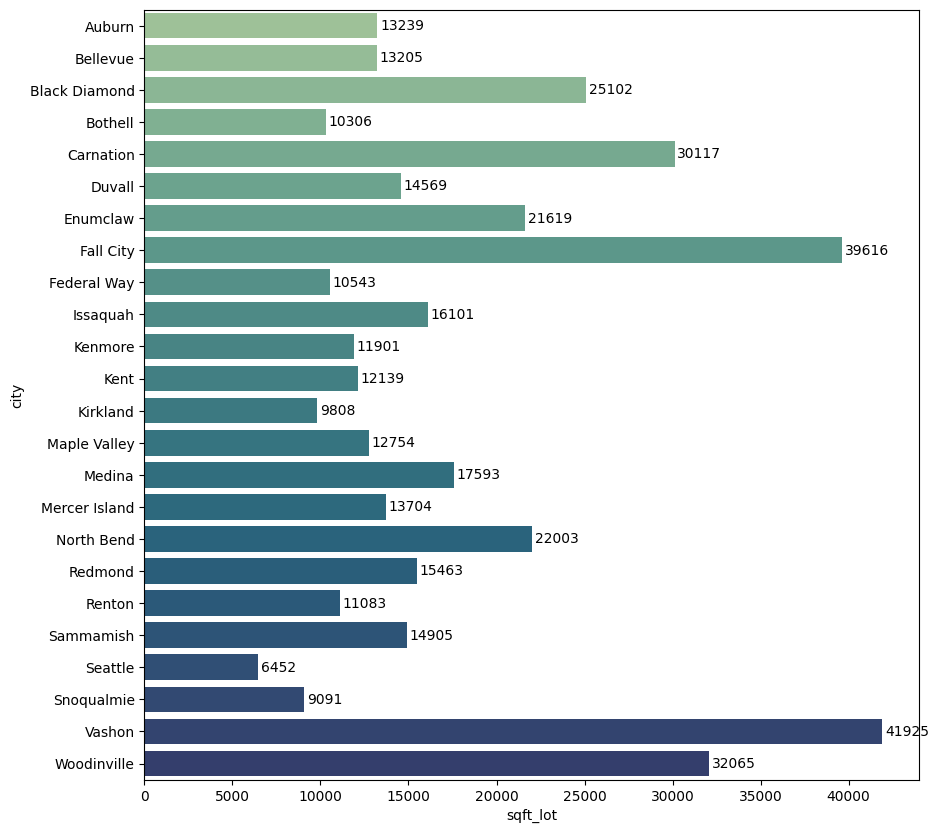

In [33]:
roof_imóveis.média_do_tamanho_do_terreno_por_cidade()

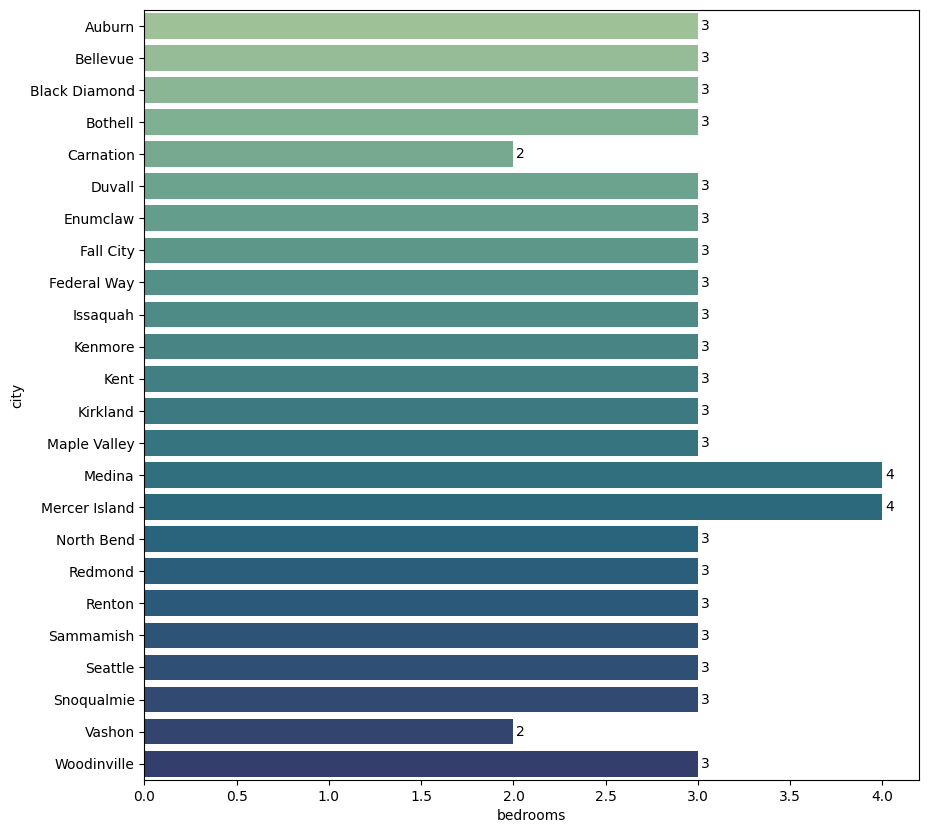

In [34]:
roof_imóveis.média_de_quantidade_quartos_por_cidade()

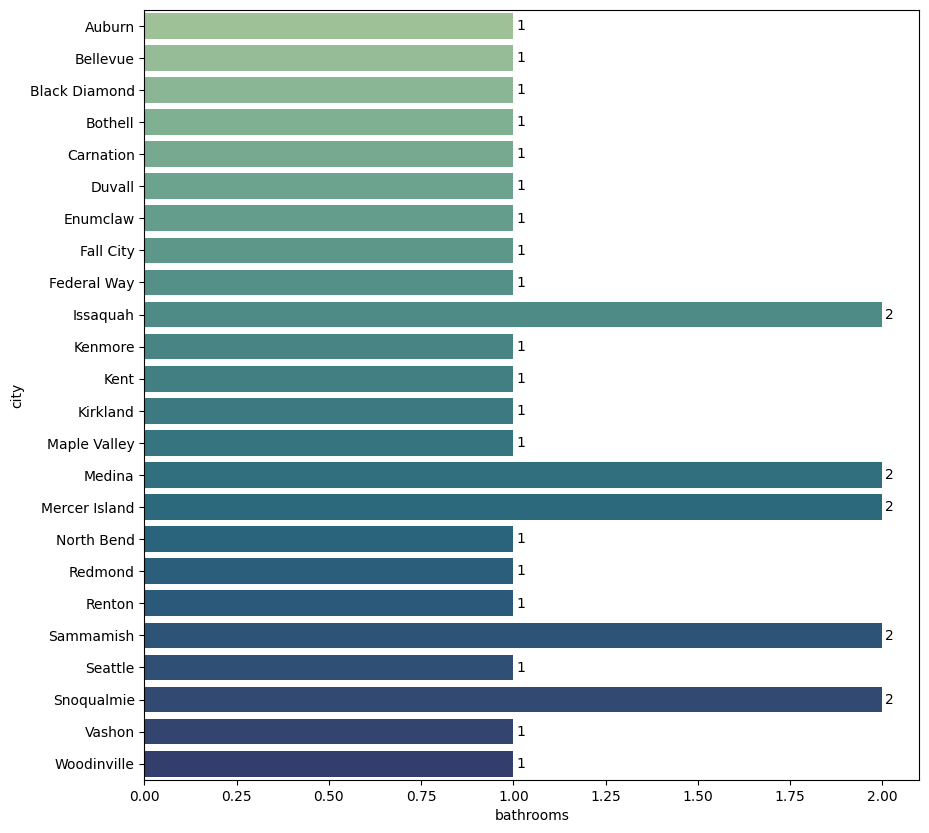

In [35]:
roof_imóveis.média_de_quantidade_banheiros_por_cidade()

In [36]:
roof_imóveis.filtrando_os_melhores_imóveis()


        Filtros:
            condition_min = 5,
            yr_built_min = 1980,
            bedrooms_min = 1,
            bathrooms_min = 1,
            price_max = 1000000.0,
        


In [37]:
roof_imóveis.algoritmo_de_rankeamento_dos_melhores_imóveis()


        Valor de cada metrica:
            Localização, top 10 cidades + populosas = 30,
            Valor do ft2 < abaixo da média da cidade = 30
            Tamanho do terreno > que a média da cidade = 20,
            Quartos > que a média da cidade = 10,
            Banheiros > que a média da cidade = 10,
        


In [38]:
roof_imóveis.os_5_melhores_imóveis()

,id,city,price,sqft_lot,price_of_ft2,price_of_ft2_per_city,condition,yr_built,bedrooms,bathrooms
0,2144800146,Seattle,257500.0,9334,27.587315,110.916887,5,1981,3,2
1,3348401382,Seattle,318000.0,12662,25.114516,110.916887,5,1982,3,2
2,2826049260,Seattle,482500.0,7626,63.270391,110.916887,5,1990,4,3
3,4022902715,Seattle,525000.0,10277,51.084947,110.916887,5,1993,5,3
4,5067400032,Seattle,550000.0,14400,38.194444,110.916887,5,1985,3,2


In [39]:
roof_imóveis.filtrando_os_piores_imóveis()


        Filtros:
            condition_max = 2,
            yr_built_max = 1980,
        


In [40]:
roof_imóveis.algoritmo_de_rankeamento_dos_piores_imóveis()


        Valor de cada metrica:
            Localização, fora do top 10 cidades + populosas = 30,
            Valor do ft2 > acima da média da cidade = 30,
            Tamanho do terreno < que a média da cidade = 20,
            Quartos < que a média da cidade = 10,
            Banheiros < que a média da cidade = 10,
        


In [41]:
roof_imóveis.os_5_piores_imóveis()

,id,city,price,sqft_lot,price_of_ft2,price_of_ft2_per_city,condition,yr_built,bedrooms,bathrooms
0,4083802195,Seattle,578888.0,4000,144.722000,110.916887,2,1914,2,2
1,2028700265,Seattle,505000.0,3816,132.337526,110.916887,2,1929,2,1
2,9407110710,North Bend,322000.0,8400,38.333333,28.573442,2,1979,3,1
3,913000340,Seattle,252000.0,1638,153.846154,110.916887,1,1910,1,1
4,3523029059,Vashon,181000.0,10807,16.748404,15.174456,2,1949,2,1


In [42]:
roof_imóveis.relatório()

Relatório criado, README.md.
